<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Moonshot Pairs Trading Strategy

This notebook introduces the Moonshot pairs trading strategy code and runs an example backtest using the ETFs GLD and GDX (Gold and Gold Miners). 

## Moonshot strategy code

The pairs trading strategy code is provided in [pairs.py](pairs.py).

### Code highlights

We define a helper method, `get_hedge_ratio`, which uses the `coint_johansen` function from the `statsmodels` library to run the Johansen cointegration test on the pair prices. The Eigenvectors produced by this function are used as the hedge ratios:

```python
def get_hedge_ratio(self, pair_prices: pd.DataFrame):
    """
    Helper function that uses the Johansen test to calculate hedge ratio. This is applied
    to the pair prices on a rolling basis in prices_to_signals.
    """
    ...
    
    # The second and third parameters indicate constant term, with a lag of 1. 
    # See Chan, Algorithmic Trading, chapter 2.
    result = coint_johansen(pair_prices, 0, 1)

    # The first column of eigenvectors contains the best weights
    weights = list(result.evec[0])

    return pd.Series(weights, index=pair_prices.columns)
```

We then call this helper method from `prices_to_signals` for each day (row) of our prices DataFrame: 

```python

closes = prices.loc["Close"]

# Calculate hedge ratios on a rolling basis. Unfortunately, pandas 
# rolling apply() won't work here, so we have to loop through each day
all_hedge_ratios = []
for idx in range(len(closes)):
    start_idx = i - self.LOOKBACK_WINDOW
    some_closes = closes.iloc[start_idx:idx]
    hedge_ratio = self.get_hedge_ratio(some_closes)
    hedge_ratio = pd.Series(hedge_ratio).to_frame().T
    all_hedge_ratios.append(hedge_ratio)

hedge_ratios = pd.concat(all_hedge_ratios)
hedge_ratios.index = closes.index
```

We then use the hedge ratios to compute the spread and calculate the Bollinger Bands:

```python
# Compute spread and Bollinger Bands (spreads and everything derived
# from it is a Series, which we later broadcast back to a DataFrame)
spreads = (closes * hedge_ratios).sum(axis=1)
means = spreads.fillna(method="ffill").rolling(self.LOOKBACK_WINDOW).mean()
stds = spreads.fillna(method="ffill").rolling(self.LOOKBACK_WINDOW).std()
upper_bands = means + self.BBAND_STD * stds
lower_bands = means - self.BBAND_STD * stds 
```

Using the Bollinger Bands, we calculate our long and short entries and exits (in the form of Boolean Series), then combine them into a single integer Series of signals, which we then broadcast back to the shape of our original DataFrame:

```python
# Long (short) the spread when it crosses below (above) the lower (upper) 
# band, then exit when it crosses the mean
long_entries = spreads < lower_bands
long_exits = spreads >= means
short_entries = spreads > upper_bands
short_exits = spreads <= means

# Combine entries and exits
ones = pd.Series(1, index=spreads.index)
zeros = pd.Series(0, index=spreads.index)
minus_ones = pd.Series(-1, index=spreads.index)
long_signals = ones.where(long_entries).fillna(zeros.where(long_exits)).fillna(method="ffill")
short_signals = minus_ones.where(short_entries).fillna(zeros.where(short_exits)).fillna(method="ffill")
signals = long_signals + short_signals

# Broadcast Series of signals to DataFrame
signals = closes.apply(lambda x: signals)
```

In `signals_to_target_weights`, we re-use the hedge ratios to convert the integer signals into percentage weights indicating how much of each instrument to hold: 

```python
# hedge_ratios represents ratios of shares, multiply by price to get ratios
# of weights
hedge_ratio_weights = self.hedge_ratios * prices.loc["Close"]

# Multiply weight ratios by signals to get target weights, then reduce to 
# 1X total allocation
weights = signals * hedge_ratio_weights 
total_weights= weights.abs().sum(axis=1)
weights = weights.div(total_weights, axis=0)
```

In `target_weights_to_positions` and `positions_to_gross_returns`, we simulate entering or exiting the position at the next day's opening price.


### Install strategy file

Moonshot looks for strategies inside the "moonshot" directory, so execute the following cell to "install" the strategy by moving the file to that location: 

In [1]:
# make directory if doesn't exist
!mkdir -p /codeload/moonshot

!mv pairs.py /codeload/moonshot/

## Example Backtest Using GLD and GDX

Before searching for pairs in the next notebook, we first run a backtest on GLD (Gold) and GDX (Gold Miners), one of the pairs discussed in Chan's book.

To do so, look up the conids for these ETFs (shown here using the CLI):

In [2]:
!quantrocket master get -s GLD GDX -v usstock -f Symbol | csvlook -I

| Sid            | Symbol |
| -------------- | ------ |
| FIBBG000CRF6Q8 | GLD    |
| FIBBG000PLNQN7 | GDX    |


The `pairs.py` file contains a subclass for this pair:

```python
class GDX_GLD_Pair(PairsStrategy):
    
    CODE = "pairs-gdx-gld"
    DB = "usa-etf-1d-p"
    SIDS = [
        "FIBBG000PLNQN7", # GDX
        "FIBBG000CRF6Q8", # GLD
    ]
```

We're ready to run the backtest:

In [3]:
from quantrocket.moonshot import backtest
backtest("pairs-gdx-gld", start_date="2011-01-01", filepath_or_buffer="pairs_results_gdx_gld.csv")

And look at the tearsheet, which shows good performance around the time Chan's book was published but poor performance after 2015:

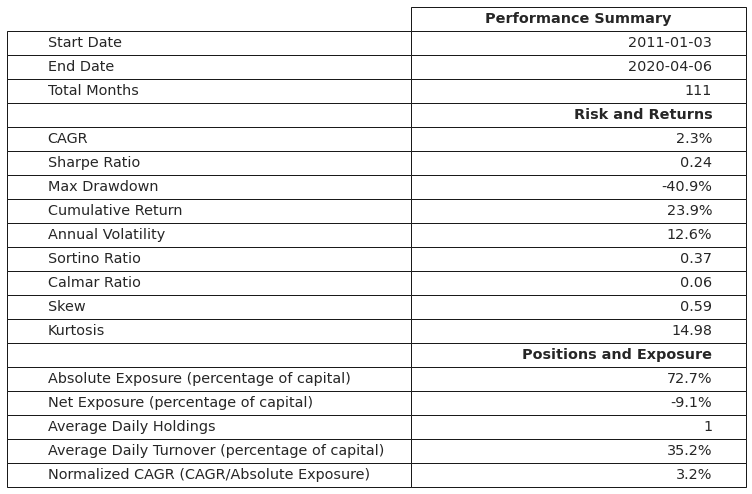

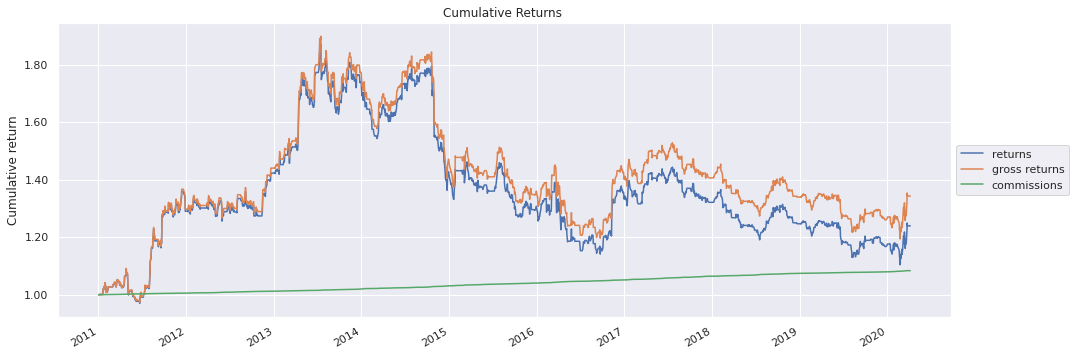

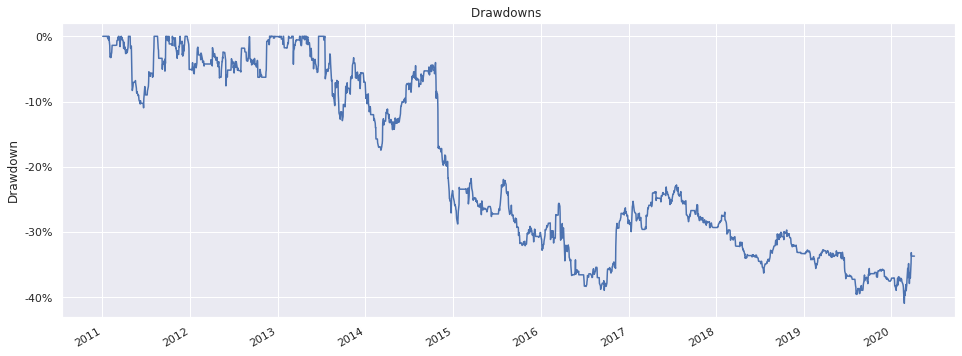

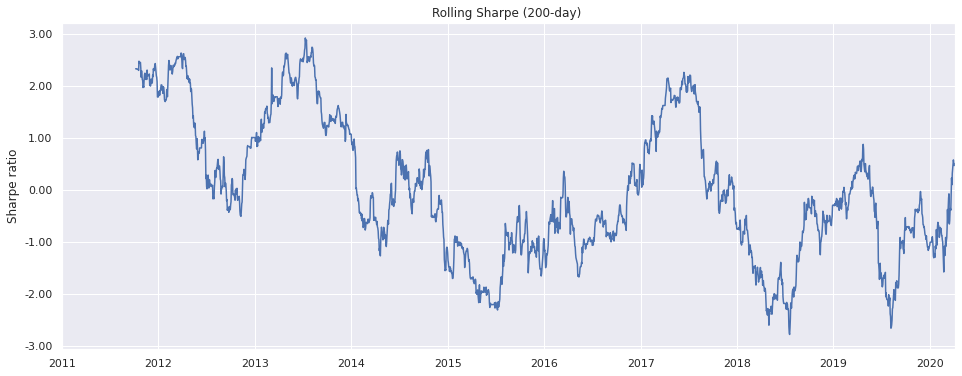

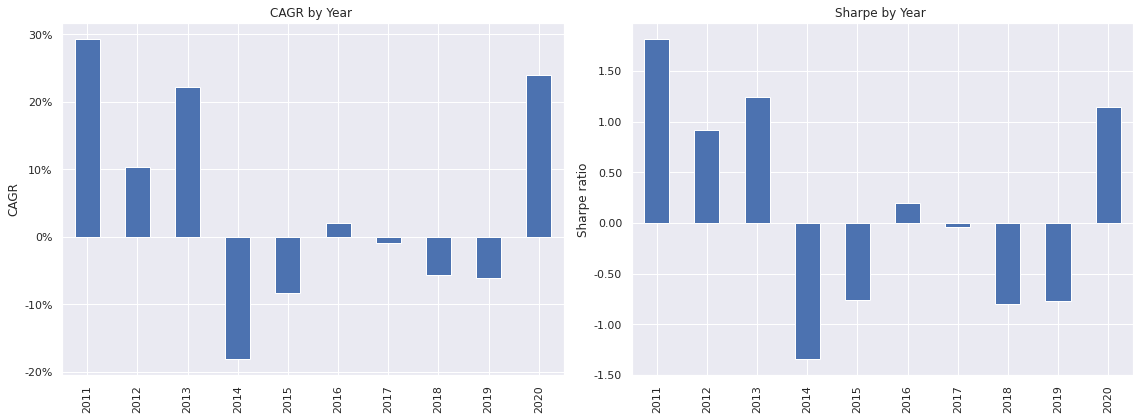

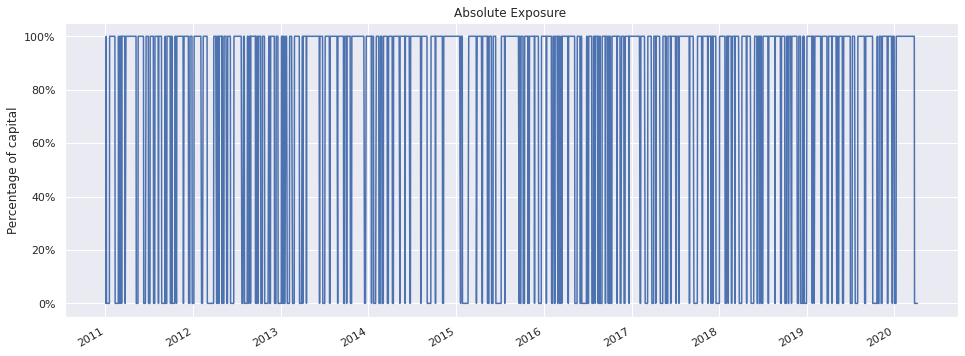

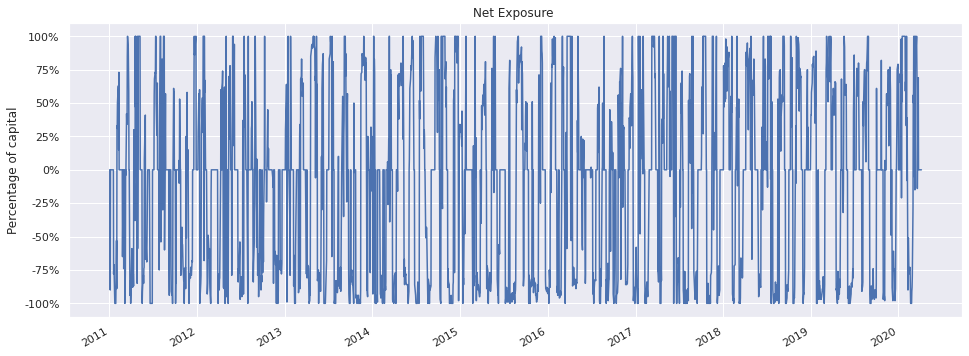

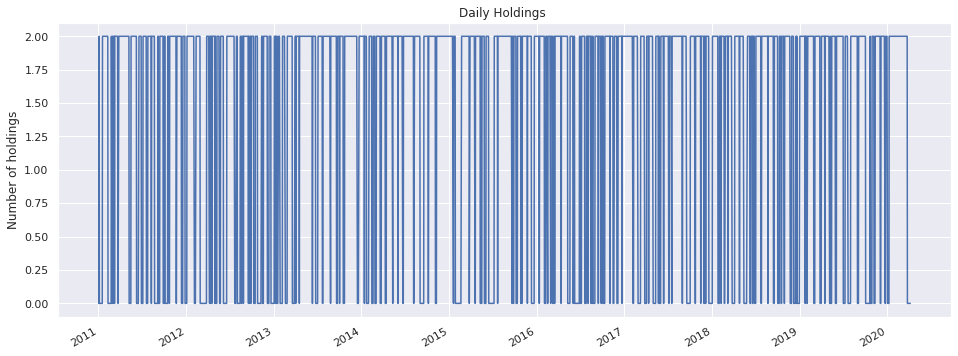

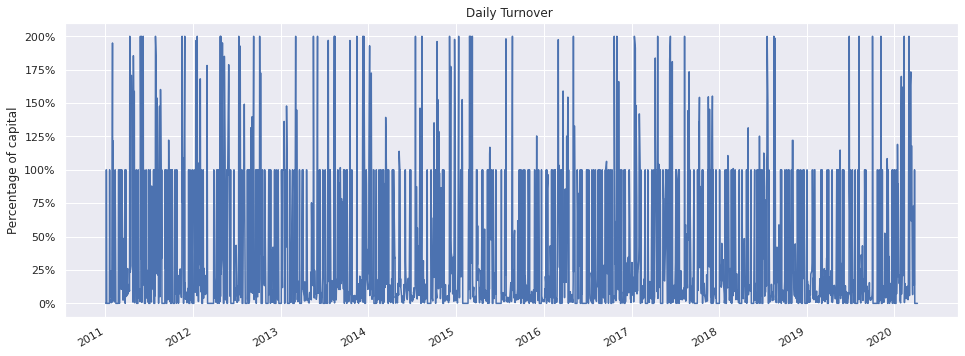

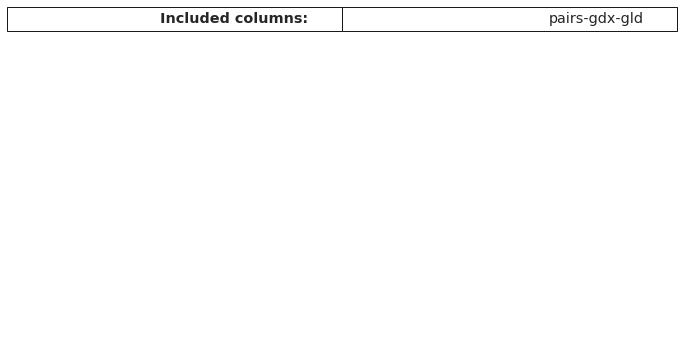

In [4]:
from moonchart import Tearsheet
Tearsheet.from_moonshot_csv("pairs_results_gdx_gld.csv")

***

## *Next Up*

Part 3: [Pairs Selection Pipeline](Part3-Pairs-Selection-Pipeline.ipynb)